In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
print(torch.__version__)
from torchsummary import summary
from torchvision.utils import save_image

1.8.0+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#https://github.com/zacheberhart/Convolutional-Disentangled-Variational-Autoencoder/blob/master/Convolutional%20Disentangled%20Variational%20Autoencoder%20(%CE%B2-VAE).ipynb

In [4]:
# EPOCH = 10
# BATCH_SIZE = 32
# LR = 0.005
# path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks/train_test_imbal/'
path = '/content/drive/MyDrive/ecg/'

In [5]:
train_mlii = np.loadtxt(path+ "train_test_sampled_mlii/train_mlii.csv", delimiter=',')
test_mlii = np.loadtxt(path+"train_test_sampled_mlii/test_mlii.csv", delimiter=',')

print(train_mlii.shape)
print(test_mlii.shape)

(28936, 259)
(27207, 259)


In [6]:
X_train_old = train_mlii[:,:-3]
y_train_old = train_mlii[:,-3]
X_test_old = test_mlii[:,:-3]
y_test_old = test_mlii[:,-3]

In [7]:
# X_train_old = np.loadtxt(path + 'X_train.csv', delimiter=',')
# y_train_old = np.loadtxt(path + 'y_train.csv', delimiter=',')
# X_test_old = np.loadtxt(path + 'X_test.csv', delimiter=',')
# y_test_old = np.loadtxt(path + 'y_test.csv', delimiter=',')

In [8]:
# print(X_train_old.shape)
# print(y_train_old.shape)
# print(X_test_old.shape)
# print(y_test_old.shape)

In [9]:
num = 8.0

In [10]:
y_train = y_train_old[np.where(y_train_old == num)[0]]
X_train = X_train_old[np.where(y_train_old == num)[0]]
X_test = X_test_old[np.where(y_test_old == num)[0]]
y_test = y_test_old[np.where(y_test_old == num)[0]]

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3617, 256)
(3617,)
(1744, 256)
(1744,)


In [12]:
X_train = np.expand_dims(X_train,axis=1)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=1)
print(X_test.shape)

(3617, 1, 256)
(1744, 1, 256)


In [13]:
# print(len(train_loader.dataset))

In [14]:
# NC = 1    # channels
# NEF = 30  # init encoding filters
# NDF = 30  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims, number_of_features, hidden_size, hidden_layer_depth, sequence_length, batch_size, dropout, beta, beta_delta):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        self.number_of_features = number_of_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        # self.latent_length = latent_length
        self.sequence_length = sequence_length
        self.batch_size=batch_size
        self.beta = beta
        self.beta_delta = beta_delta


        self.encoder = nn.LSTM(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)


        self.decoder = self.model = nn.LSTM(1, self.hidden_size, self.hidden_layer_depth)
        
        # conv fc
        self.fc11 = nn.Linear(self.hidden_size, self.zdims) # mu
        self.fc12 = nn.Linear(self.hidden_size, self.zdims) # logvar
        
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.number_of_features)

        self.decoder_inputs = torch.zeros(self.sequence_length, self.batch_size, 1, requires_grad=True).type(torch.cuda.FloatTensor)
        self.c_0 = torch.zeros(self.hidden_layer_depth, self.batch_size, self.hidden_size, requires_grad=True).type(torch.cuda.FloatTensor)


        # nn.init.xavier_uniform_(self.fc11.weight)
        # nn.init.xavier_uniform_(self.fc12.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        # nn.init.xavier_uniform_(self.fc3.weight)


    def encode(self, x):

        _, (h_end, c_end) = self.encoder(x)

        h_end = h_end[-1, :, :] # !!!!!!!!!!!!!

        mu = self.fc11(h_end)
        logvar = self.fc12(h_end)

        return mu, logvar
    
    def decode(self, z):

        h_state = F.relu(self.fc2(z)) # try without relu


        h_0 = torch.stack([h_state for _ in range(self.hidden_layer_depth)])
        decoder_output, _ = self.model(self.decoder_inputs, (h_0, self.c_0))

        # deconv_input = torch.unsqueeze(deconv_input,2)# world models: [-1, 1, 1, 1024] # and this # 30,1024,430
        # print("after view", deconv_input.shape)
        # recon_x = self.decoder(deconv_input)

        out = self.fc3(decoder_output)
        return out
        # return recon_x

    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        return z
    
    def forward(self, x):
        # print("forward", x.shape)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # print(z.shape, "z, forward")
        recon_x = self.decode(z)
        # recon_x = recon_x.permute(0,2,1)
        return recon_x, mu, logvar, z

    def update_beta(self):
      self.beta += self.beta_delta

In [15]:
print(X_train.shape)

(3617, 1, 256)


In [16]:
CUDA = True

ZDIMS = 20
# BETA = 5
LR = 1e-3
EPOCHS = 25
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 100



hidden_size = 90
hidden_layer_depth = 4
# latent_length = 20
batch_size = 64
learning_rate = 0.0005
n_epochs = 10
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = False
sequence_length = X_train.shape[1]
features = X_train.shape[2]
beta=0.1
beta_delta=0

In [17]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [18]:
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [19]:
tensor_Xtest = torch.from_numpy(X_test)
tensor_ytest = torch.from_numpy(y_test)

test_data = Data.TensorDataset(tensor_Xtest, tensor_ytest)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [20]:
model = VAE(zdims = ZDIMS, number_of_features=features,hidden_size=hidden_size, hidden_layer_depth=hidden_layer_depth, sequence_length= sequence_length, batch_size=batch_size, dropout=dropout_rate, beta=beta, beta_delta=beta_delta).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [21]:
print(model)

VAE(
  (encoder): LSTM(256, 90, num_layers=4, dropout=0.2)
  (decoder): LSTM(1, 90, num_layers=4)
  (model): LSTM(1, 90, num_layers=4)
  (fc11): Linear(in_features=90, out_features=20, bias=True)
  (fc12): Linear(in_features=90, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=256, bias=True)
)


In [22]:
def loss_function(recon_x, x, mu, logvar, beta = 1):
    '''Use a beta value of 1 for a vanilla VAE'''
    # print(recon_x.shape, "recon_x")
    # print(x.shape, "x")
    # loss
    # BCE = F.binary_cross_entropy(recon_x, x, reduction = 'sum')
    MSE = F.mse_loss(recon_x,x,reduction= 'mean')
    # KL Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print("MSE", MSE)
    # print("KLD", KLD)
    return MSE + (model.beta * KLD), KLD, MSE

In [23]:
def train(epoch):
    # import pdb; pdb.set_trace()

    model.train()
    train_loss = 0
    kld_loss = 0
    mse_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        # data = data[0]
        data = data.to(device)
        # print("data", data.shape)
        data = data.permute(1,0,2)
        optimizer.zero_grad()

        recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))

        
        loss, kld, mse = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        kld_loss += kld.item()
        mse_loss += mse.item()
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), kld_loss / len(train_loader.dataset), mse_loss / len(train_loader.dataset)

In [24]:
train_loss_list = []
kld_list = []
mse_list = []
for epoch in range(50):
    loss, kld, mse = train(epoch)
    train_loss_list.append(loss)
    kld_list.append(kld)
    mse_list.append(mse)

Train Epoch: 0 [0/3617 (0%)]	Loss: 1.408454
====> Epoch: 0 Average loss: 0.0103
Train Epoch: 1 [0/3617 (0%)]	Loss: 0.437538
====> Epoch: 1 Average loss: 0.0064
Train Epoch: 2 [0/3617 (0%)]	Loss: 0.481454
====> Epoch: 2 Average loss: 0.0064
Train Epoch: 3 [0/3617 (0%)]	Loss: 0.426317
====> Epoch: 3 Average loss: 0.0064
Train Epoch: 4 [0/3617 (0%)]	Loss: 0.406412
====> Epoch: 4 Average loss: 0.0064
Train Epoch: 5 [0/3617 (0%)]	Loss: 0.404426
====> Epoch: 5 Average loss: 0.0064
Train Epoch: 6 [0/3617 (0%)]	Loss: 0.418542
====> Epoch: 6 Average loss: 0.0064
Train Epoch: 7 [0/3617 (0%)]	Loss: 0.408603
====> Epoch: 7 Average loss: 0.0064
Train Epoch: 8 [0/3617 (0%)]	Loss: 0.440349
====> Epoch: 8 Average loss: 0.0064
Train Epoch: 9 [0/3617 (0%)]	Loss: 0.418602
====> Epoch: 9 Average loss: 0.0064
Train Epoch: 10 [0/3617 (0%)]	Loss: 0.337873
====> Epoch: 10 Average loss: 0.0064
Train Epoch: 11 [0/3617 (0%)]	Loss: 0.368530
====> Epoch: 11 Average loss: 0.0064
Train Epoch: 12 [0/3617 (0%)]	Loss: 

In [25]:
def plot_image(img, ax, title):
    view_data = img
    time_value = np.arange(256, dtype = 'float')
    ax.plot(time_value, view_data)
    ax.set_title(title, fontsize=20)


def plot_encoding(image, model, latent_sz, alpha=1, width=1/7):
    image = image[0]
    image.to(device)
    image = image.permute(1,0,2)
    decoded, mu, logvar, z = model.forward(image.type(torch.cuda.FloatTensor))
    z = model.reparameterize(mu, logvar)
    img = model.decode(z).view(-1,256).detach().cpu().numpy()
    z = z.cpu().detach().numpy()[0]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    plot_image(image[0,0,:], ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d" % latent_sz, fontsize=20)
    
    plot_image(img[0,:], ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

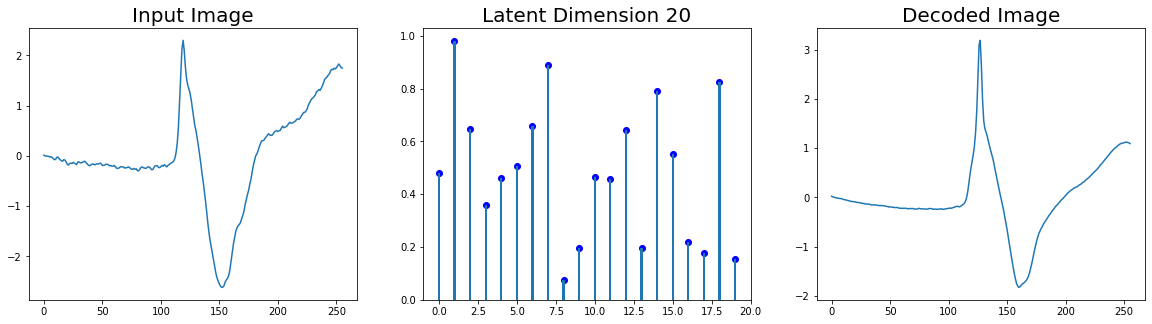

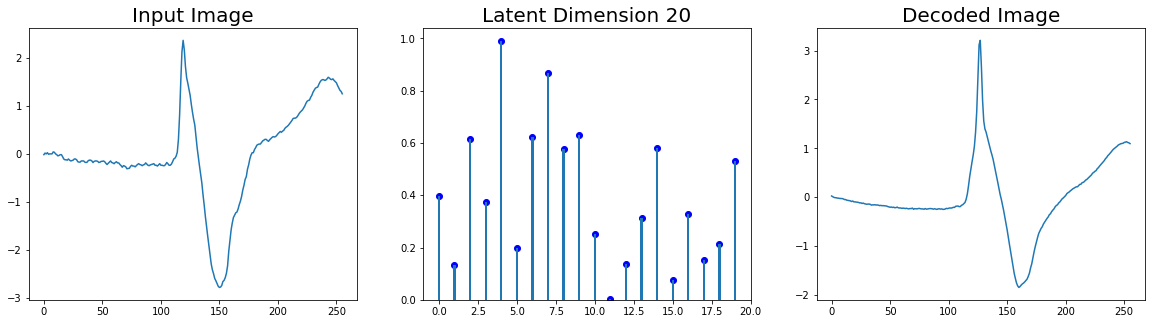

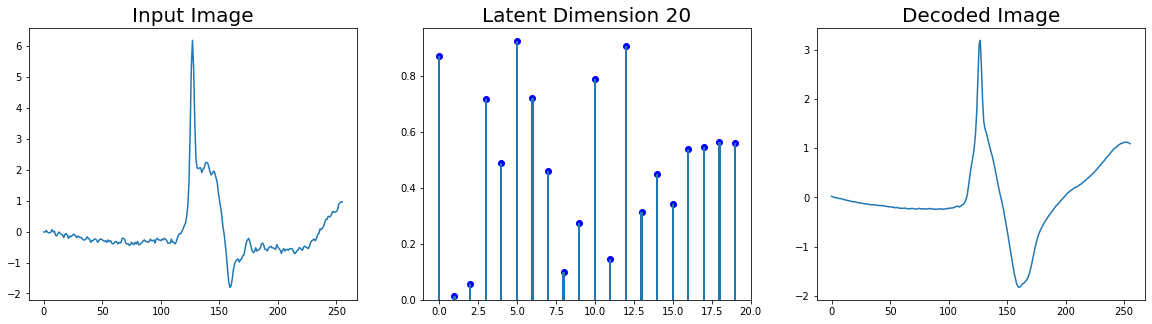

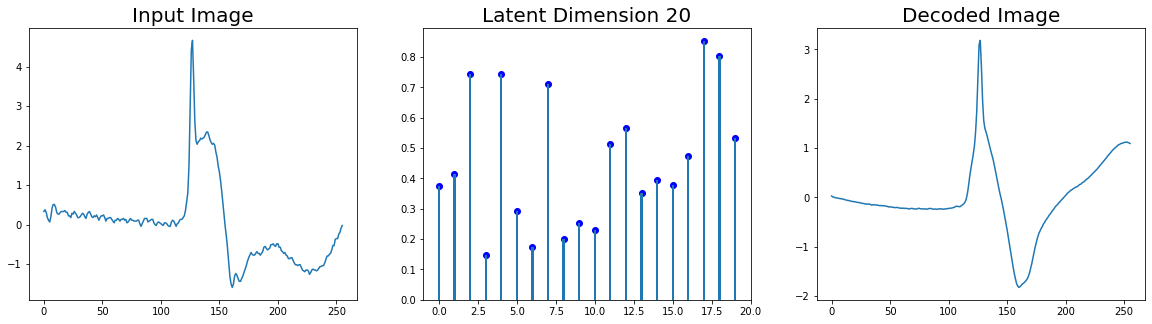

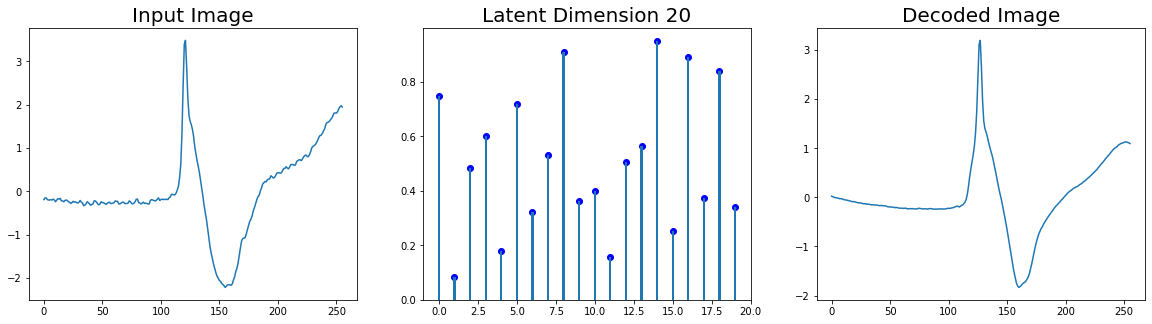

In [26]:
dataloader_iterator = iter(train_loader)
for i in range(5):
    try:
        img = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(train_loader)
        img = next(dataloader_iterator)
    plot_encoding(img, model, ZDIMS)

In [27]:
# from sklearn.manifold import TSNE 
# latent_ecg = []
# target = []
# for data, targets in train_loader:
#     z_means, z_logvar = model.encode(data.permute(1,0,2).type(torch.cuda.FloatTensor))
#     # print(z_means.shape)
#     latent_ecg.extend(z_means.detach().cpu().numpy())
#     target.extend(targets.numpy())

# # take first 1k
# latent = np.array(latent_ecg)
# # print(latent.shape)
# target = np.array(target)
# tsne = TSNE(n_components=2, random_state=0, verbose=2, n_iter=500, perplexity=100)

# X = tsne.fit_transform(latent_ecg)

In [28]:
# plt.figure(figsize=(8,8))
# scatter = plt.scatter(X[:,0], X[:,1], c=target)
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('TSNE')
# plt.show()

In [29]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    kld_loss_tst = 0
    mse_loss_tst = 0
    recon_list = []
    with torch.no_grad():
        
        for i, (data, _) in enumerate(test_loader):
            # data = data[0]
            data = data.to(device)
            data= data.permute(1,0,2)
            # data_reshape = data.view(len(data), 1, 256).type(torch.cuda.FloatTensor)
            recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
            recon_list.append(recon_batch)
            # print(recon_batch.shape)
            loss, kld, mse = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
            test_loss += loss.item()
            kld_loss_tst += kld.item()
            mse_loss_tst += mse.item()
          
            # if i == 0:
    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n], recon_batch[:n]])
    # print(comparison)
    # save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
    if(epoch==99):
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data[:5].view(-1, 256).type(torch.cuda.FloatTensor)
      view_recon = recon_batch[:5].view(-1, 256).type(torch.cuda.FloatTensor)

      for i in range(5):
          a[0][i].plot(view_data.detach().cpu().numpy()[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon.detach().cpu().numpy()[i])
      plt.show();
    test_loss /= len(test_loader.dataset)
    kld_loss_tst /= len(test_loader.dataset)
    mse_loss_tst /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, kld_loss_tst, mse_loss_tst, recon_list

In [30]:
test_loss_list = []
kld_list_tst = []
mse_list_tst = []
for epoch in range(50):
    loss, kld, mse, recon_list = test(epoch)
    test_loss_list.append(loss)
    kld_list_tst.append(kld)
    mse_list_tst.append(mse)

====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0066
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0066
====> Test set loss: 0.0066
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0066
====> Test set loss: 0.0065
====> Test set loss: 0.0066
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0066
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0066
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0066
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss: 0.0065
====> Test set loss:

In [31]:
copy_recon = recon_list
recon_all = torch.cat(copy_recon, dim=1)
print(recon_all.shape)

torch.Size([1, 1728, 256])


In [32]:
recon_all_1 = torch.squeeze(recon_all, dim=0)
print(recon_all_1.shape)

torch.Size([1728, 256])


In [33]:
# sample from latent space
# with torch.no_grad():
#     sample = torch.randn(64, ZDIMS).to(device)
#     print(sample.shape)
#     sample = model.decode(sample).cpu()
#     f, a = plt.subplots(1, 2, figsize=(20,5))
#     samp_view = sample.reshape(-1,256)
#     view_data = samp_view[59:64]

#     for i in range(2):
#         a[i].plot(view_data.detach().cpu().numpy()[i])

#     # for i in range(5):
#     #     a[1][i].clear()
#     #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
#     plt.show();

def sample_latent(model, no_samples):
  samples = []
  with torch.no_grad():
    for i in range(no_samples // 64):
      sample = torch.randn(64, ZDIMS).to(device)
      # print(sample.shape)
      sample = model.decode(sample).cpu()
      sample = sample.reshape(-1,256)
      # print(sample.shape)
      # sample = scaler.inverse_transform(sample.view(-1,256).cpu().data.numpy())
      # sample = sample.permute(0,2,1)
      # print(sample.shape)
      samples.append(sample)
    return samples

In [34]:
samples = sample_latent(model,3000)
print(len(samples))

46


In [35]:
print(samples[0].shape)
all_samps = np.concatenate(samples, axis=0)
print(all_samps.shape)

torch.Size([64, 256])
(2944, 256)


In [36]:
import os
sv_samps = '/content/drive/MyDrive/ecg/synthetic_data/lstm_vae/beat_type' + str(num) + '.csv'
if not os.path.exists('/content/drive/MyDrive/ecg/synthetic_data/lstm_vae/'):
  os.makedirs('/content/drive/MyDrive/ecg/synthetic_data/lstm_vae/')
np.savetxt(sv_samps, all_samps, delimiter=',', fmt='%f')

In [37]:
def view_samples(sample):
  f, a = plt.subplots(1, 5, figsize=(40,5))
  view_data = sample[30:35]

  for i in range(5):
      a[i].plot(view_data[i])

      # for i in range(5):
      #     a[1][i].clear()
      #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
  plt.show();

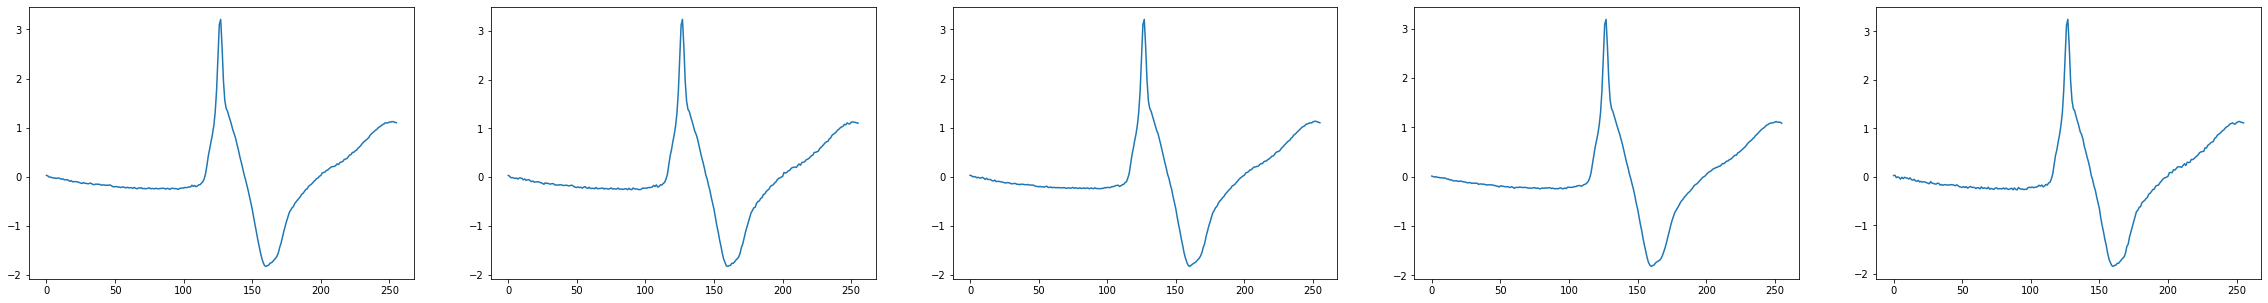

In [38]:
view_samples(all_samps)

In [39]:
check = torch.randn(64,256,1)
# check = check[0]
check = check.permute(1,0,2)
print(check.shape)

torch.Size([256, 64, 1])


In [40]:
c = torch.randn(64,256,1)
print(check[0].shape)

torch.Size([64, 1])


In [41]:
x = torch.randn(125,64)
x = torch.unsqueeze(x,2)
print(x.shape)

torch.Size([125, 64, 1])


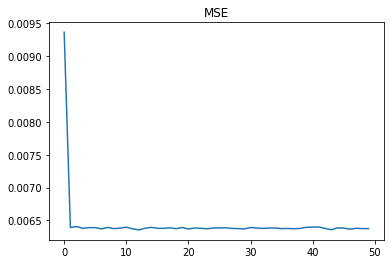

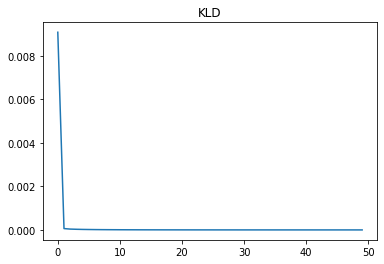

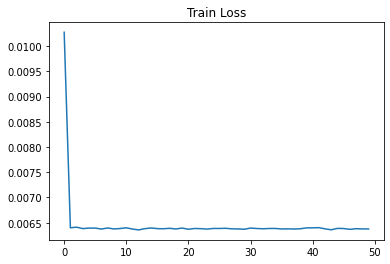

In [42]:
plt.plot(range(len(mse_list)), mse_list)
plt.title("MSE")
plt.show()
plt.plot(range(len(kld_list)), kld_list)
plt.title("KLD")
plt.show()
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.title("Train Loss")
plt.show()

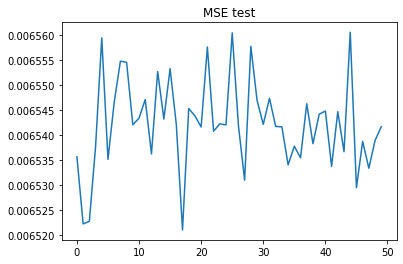

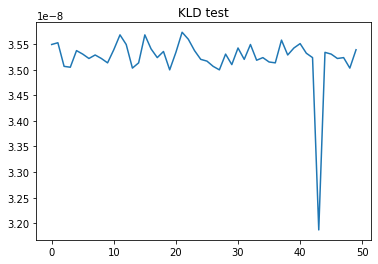

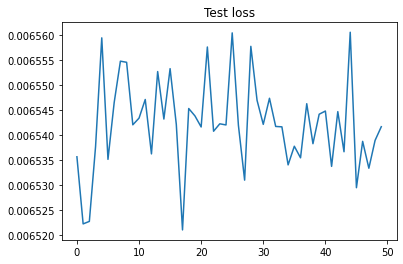

In [43]:
plt.plot(range(len(mse_list_tst)), mse_list_tst)
plt.title("MSE test")
plt.show()
plt.plot(range(len(kld_list_tst)), kld_list_tst)
plt.title("KLD test")
plt.show()
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.title("Test loss")
plt.show()

In [44]:
data = recon_all_1.detach().cpu().numpy()
classes = y_test[:-7]
print(classes.shape)

(1737,)


In [45]:
# from sklearn.decomposition import PCA
# x_pca = PCA(n_components=50,random_state=42).fit_transform(data)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_pca[:,0],x_pca[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA')

In [46]:
# from sklearn.manifold import TSNE
# x_tsne = TSNE(n_components=2,random_state=42,perplexity=100, verbose=5, n_iter=500).fit_transform(x_pca)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_tsne[:,0],x_tsne[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and TSNE')

In [47]:
# import umap
# reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=100, a = 0.5, b = 1.2)
# embedding = reducer.fit_transform(x_pca)
# embedding.shape
# plt.figure(figsize=(8,8))

# plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=classes, cmap='inferno')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and UMAP')